In [94]:
import pandas as pd
from geopy.distance import geodesic
from tqdm import tqdm  # For progress barimport matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
import numpy as np

In [50]:
old_data = pd.read_csv("data/temp_old_data.csv")
new_data = pd.read_csv("output_data/8_final_with_climate_data.csv")

old_data = old_data[old_data["Year"] >= 2010].reset_index(drop=True)
print("Filtered old_data shape:", old_data.shape)
print("Filtered new_data shape:", new_data.shape)

Filtered old_data shape: (2105, 12)
Filtered new_data shape: (3040, 28)


### Comparing Raster Data for Two Years

Below are raster data visualizations for two different years. The images are sourced from [CroplandCROS](https://croplandcros.scinet.usda.gov/).

<div style="display: flex; justify-content: space-between; align-items: center; gap: 50px;">
    <img src="pics/2005_year_screen.png" alt="Raster Data 2005" width="500" height="300" style="margin-right: 10px;">
    <img src="pics/2008_year_screen.png" alt="Raster Data 2008" width="500" height="300">
</div>

In [53]:
old_data = old_data[['Grower', 'FieldName', 'Year', 'Lat', 'Lon', 'avg_CPBA', 'avg_CPBL']]
new_data = new_data[['grower', 'field', 'year', 'lat', 'lng', 'cpba_count', 'cpbl_count', 'tmin', 'tmax', 'gdd', 'cum_gdd']]

print("Columns retained in old_data:", old_data.columns)
print("Columns retained in new_data:", new_data.columns)

Columns retained in old_data: Index(['Grower', 'FieldName', 'Year', 'Lat', 'Lon', 'avg_CPBA', 'avg_CPBL'], dtype='object')
Columns retained in new_data: Index(['grower', 'field', 'year', 'lat', 'lng', 'cpba_count', 'cpbl_count',
       'tmin', 'tmax', 'gdd', 'cum_gdd'],
      dtype='object')


In [55]:
old_data = old_data.rename(columns={
    'Grower': 'grower',
    'FieldName': 'field',
    'Year': 'year',
    'Lat': 'lat',
    'Lon': 'lng',
    'avg_CPBA': 'cpba_count',
    'avg_CPBL': 'cpbl_count'
})

print("Renamed old_data columns:", old_data.columns)

Renamed old_data columns: Index(['grower', 'field', 'year', 'lat', 'lng', 'cpba_count', 'cpbl_count'], dtype='object')


In [57]:
old_data

,grower,field,year,lat,lng,cpba_count,cpbl_count
0,B and D,10th St,2011,44.129579,-90.066432,2.246667,7.506667
1,B and D,10th St,2014,44.129579,-90.066432,2.400000,3.925000
2,B and D,10th St,2017,44.129579,-90.066432,2.400000,5.640000
3,B and D,12th St,2012,44.107952,-90.050683,1.095455,3.472727
4,B and D,12th St,2015,44.107952,-90.050683,4.322222,8.705556
...,...,...,...,...,...,...,...
2100,Weekly Farms,Woyak House,2015,44.242021,-89.605325,1.646667,2.360000
2101,Weekly Farms,Woyak Shop,2014,44.243123,-89.612972,2.060000,3.293333
2102,Weekly Farms,Woyak Shop,2017,44.243123,-89.612972,0.000000,0.000000
2103,Weekly Farms,Woyak Shop N,2017,44.244866,-89.612918,6.664286,7.892857


In [59]:
new_data

,grower,field,year,lat,lng,cpba_count,cpbl_count,tmin,tmax,gdd,cum_gdd
0,Wisconsin Central Farms,1 Necedah,2014,44.057164,-90.040412,3.307692,3.900000,44.815974,83.173633,13.772113,1727.895721
1,Wisconsin Central Farms,13 Nepco N 1/2,2014,44.209406,-90.021382,4.562500,8.714286,45.498328,79.713370,12.804045,1258.997050
2,Wisconsin Central Farms,16 13th St,2014,44.100775,-90.050524,1.637500,2.190000,45.224964,82.761841,14.263578,1688.066890
3,Wisconsin Central Farms,26 Huebner,2014,44.171606,-89.975877,2.181818,4.555556,45.584387,82.216665,13.292737,1500.892541
4,Wisconsin Central Farms,7 N Home,2014,44.329762,-89.931300,1.200000,5.500000,45.715179,78.727568,12.237354,1011.682193
...,...,...,...,...,...,...,...,...,...,...,...
3035,Alsum Farms,Krakora,2023,43.933603,-89.692766,3.000000,0.625000,52.470752,91.396768,17.571952,2100.082737
3036,Alsum Farms,Miller Wiper,2023,43.939886,-89.640232,4.615385,0.833333,43.857522,91.845835,16.939545,2150.073684
3037,Alsum Farms,060,2023,43.195788,-90.195070,7.100000,2.500000,50.977209,90.478107,17.218601,2080.094819
3038,Weekly Farms,Mykesen East,2023,44.309288,-89.373096,3.769231,4.615385,45.963541,92.744648,17.568001,1942.836999


### Matching Part

We matched fields based on location (within a specified tolerance) and then by year:
- **Matched**: If both location and year are the same. For these fields, we decided to use the new abundance rates. Below are plots showing the differences between the new and old abundance rates for matched fields.
- **Unmatched (Year)**: If the location matches within the tolerance but the year does not, these fields need to be added to the new dataset.
- **Unmatched (Location)**: If the locations do not match within the tolerance, these are considered different fields and also need to be added to the new dataset.

The goal is to identify unmatched fields and integrate them into the new dataset.

In [62]:
from geopy.distance import geodesic
from tqdm import tqdm

#old_data_sample = old_data.sample(frac=0.1, random_state=42).reset_index(drop=True)
#new_data_sample = new_data.sample(frac=0.1, random_state=42).reset_index(drop=True)
old_data_sample = old_data
new_data_sample = new_data

tolerance = 350

matched = []
unmatched_year = []
unmatched = []

In [64]:
# Matching logic
for _, old_row in tqdm(old_data_sample.iterrows(), total=len(old_data_sample), desc="Processing Matching"):
    match_idx = None
    min_distance = float('inf')

    # Find the nearest location in new_data_sample
    for idx, new_row in new_data_sample.iterrows():
        distance = geodesic((old_row['lat'], old_row['lng']), (new_row['lat'], new_row['lng'])).meters
        if distance < min_distance:
            min_distance = distance
            match_idx = idx

    # Categorize based on location and year
    if match_idx is not None and min_distance <= tolerance:
        new_row = new_data_sample.loc[match_idx]
        if old_row['year'] == new_row['year']:
            # Matched on location and year
            matched.append({
                "old_grower": old_row['grower'],
                "old_field": old_row['field'],
                "old_year": old_row['year'],
                "old_loc": (old_row['lat'], old_row['lng']),
                "old_cpba": old_row['cpba_count'],
                "old_cpbl": old_row['cpbl_count'],
                "new_grower": new_row['grower'],
                "new_field": new_row['field'],
                "new_year": new_row['year'],
                "new_loc": (new_row['lat'], new_row['lng']),
                "new_cpba": new_row['cpba_count'],
                "new_cpbl": new_row['cpbl_count'],
                "distance_m": min_distance
            })
        else:
            # Location matches but years differ
            unmatched_year.append({
                "old_grower": old_row['grower'],
                "old_field": old_row['field'],
                "old_year": old_row['year'],
                "old_loc": (old_row['lat'], old_row['lng']),
                "old_cpba": old_row['cpba_count'],
                "old_cpbl": old_row['cpbl_count']
            })
    else:
        # Completely unmatched location
        if match_idx is not None:
            new_row = new_data_sample.loc[match_idx]
            unmatched.append({
                "old_grower": old_row['grower'],
                "old_field": old_row['field'],
                "old_year": old_row['year'],
                "old_loc": (old_row['lat'], old_row['lng']),
                "old_cpba": old_row['cpba_count'],
                "old_cpbl": old_row['cpbl_count'],
                "new_grower": new_row['grower'],
                "new_field": new_row['field'],
                "new_year": new_row['year'],
                "new_loc": (new_row['lat'], new_row['lng']),
                "new_cpba": new_row['cpba_count'],
                "new_cpbl": new_row['cpbl_count'],
                "distance_m": min_distance
            })
        else:
            unmatched.append({
                "old_grower": old_row['grower'],
                "old_field": old_row['field'],
                "old_year": old_row['year'],
                "old_loc": (old_row['lat'], old_row['lng']),
                "old_cpba": old_row['cpba_count'],
                "old_cpbl": old_row['cpbl_count'],
                "new_grower": None,
                "new_field": None,
                "new_year": None,
                "new_loc": None,
                "new_cpba": None,
                "new_cpbl": None,
                "distance_m": None
            })

Processing Matching: 100%|██████████████████| 2105/2105 [08:09<00:00,  4.30it/s]


In [66]:
matched_df = pd.DataFrame(matched)
unmatched_year_df = pd.DataFrame(unmatched_year)
unmatched_df = pd.DataFrame(unmatched)

total_rows = len(matched_df) + len(unmatched_year_df) + len(unmatched_df)
print(f"Total rows processed: {total_rows}, Expected: {len(old_data_sample)}")
assert total_rows == len(old_data_sample), "Row count mismatch! Check logic."

matched_df_sorted = matched_df.sort_values(by='distance_m', ascending=True)
unmatched_df_sorted = unmatched_df.sort_values(by='distance_m', ascending=True)

# Print sorted tables
print("Matched Fields Sample (Sorted by Distance):")
print(matched_df_sorted.head())

print("\nUnmatched Fields Sample (Different Location, Sorted by Distance):")
print(unmatched_df_sorted.head())

print("\nUnmatched Year Fields Sample (Same Location, Different Year):")
print(unmatched_year_df.head())

Total rows processed: 2105, Expected: 2105
Matched Fields Sample (Sorted by Distance):
           old_grower  old_field  old_year                      old_loc  \
745  Specialty Potato    Dewey 7      2018  (44.60840214, -89.52181272)   
426   Heartland Farms       J-07      2015  (44.24755086, -89.40150725)   
845      Weekly Farms  Slinger 1      2014  (44.15974942, -89.57769797)   
474   Heartland Farms       P-20      2015  (44.13189483, -89.48939575)   
432   Heartland Farms       J-14      2015    (44.23981235, -89.380142)   

     old_cpba  old_cpbl          new_grower  new_field  new_year  \
745  1.821429  5.107143  Specialty Potatoes    Dewey 7      2018   
426  3.050000  6.121429     Heartland Farms        J-7      2015   
845  1.720000  3.180000        Weekly Farms  Slinger 1      2014   
474  0.871429  2.735714     Heartland Farms       P-20      2015   
432  1.414286  4.621429     Heartland Farms       J-14      2015   

                         new_loc  new_cpba  new_cpbl 

In [134]:
matched_df_sorted.tail(20)

,old_grower,old_field,old_year,old_loc,old_cpba,old_cpbl,new_grower,new_field,new_year,new_loc,new_cpba,new_cpbl,distance_m,cpba_diff,cpbl_diff
856,Weekly Farms,Woyak Shop N,2017,"(44.24486619, -89.61291828)",6.664286,7.892857,Weekly Farms,Woyak Shop N,2017,"(44.24304572, -89.6128919)",4.384615,4.333333,202.296150,-2.279670,-3.559524
796,Taterland,Harris Stone,2015,"(44.2375328, -89.53233859)",1.306667,2.300000,Taterland,Harris Stone,2015,"(44.23767945, -89.53487269)",1.451667,1.643571,203.092414,0.145000,-0.656429
395,Heartland Farms,H-64,2014,"(44.09040273, -89.57787267)",3.271429,5.921429,Heartland Farms,H-64,2014,"(44.08855717, -89.57783452)",1.964286,3.221429,205.090293,-1.307143,-2.700000
442,Heartland Farms,J-40 E,2014,"(44.17766528, -89.40816116)",1.292308,3.192308,Heartland Farms,J-40 E,2014,"(44.17764777, -89.41073576)",0.666667,1.750000,205.890889,-0.625641,-1.442308
471,Heartland Farms,P-16,2015,"(44.13909432, -89.47881856)",0.707143,2.478571,Heartland Farms,P-16,2015,"(44.1390706, -89.47621715)",0.560000,1.910000,208.177853,-0.147143,-0.568571
472,Heartland Farms,P-17,2015,"(44.13909443, -89.47352745)",0.000000,0.000000,Heartland Farms,P-16,2015,"(44.1390706, -89.47621715)",0.560000,1.910000,215.242297,0.560000,1.910000
686,Mortenson,Klabunde S,2018,"(44.10867326, -89.47637208)",2.205882,1.570588,Mortenson Brothers,Klabunde S,2018,"(44.10857528, -89.47906362)",1.550000,0.866667,215.758779,-0.655882,-0.703922
746,Specialty Potato,Dombrowski E,2016,"(44.67183288, -89.40824995)",1.358333,5.708333,Specialty Potatoes,Tony's Wilderness,2016,"(44.67142565, -89.41097389)",2.000000,2.545455,220.686888,0.641667,-3.162879
633,James Burns,Morrells W,2014,"(44.23978173, -89.42761169)",0.000000,0.000000,James Burns & Sons,30 Morrells,2014,"(44.23975278, -89.42478378)",1.384615,3.545455,225.923392,1.384615,3.545455
631,James Burns,Morells E,2014,"(44.23981809, -89.42192853)",0.000000,0.000000,James Burns & Sons,30 Morrells,2014,"(44.23975278, -89.42478378)",1.384615,3.545455,228.199827,1.384615,3.545455


In [78]:
old_datav1 = pd.read_csv("data/temp_old_data.csv")
old_datav1[(old_datav1['Grower']=='Weekly Farms')&(old_datav1['FieldName'] == 'Tibbets N/Lisak')]

,Grower,FieldName,Year,Lat,Lon,avg_CPBA,avg_CPBL,avg_CPBE,Area_ha,Area_ac,WTM_X,WTM_Y
3780,Weekly Farms,Tibbets N/Lisak,2016,44.206419,-89.573525,3.741935,5.032258,0.054839,78.335957,193.571592,554073.4648,414888.1422


In [104]:
print(old_datav1[(old_datav1['Grower']=='Heartland Farms')&(old_datav1['FieldName'] == 'P-17')&(old_datav1['Year'] == 2015)]['Area_ha'])
print(old_datav1[(old_datav1['Grower']=='Helbach Farms')&(old_datav1['FieldName'] == 'J-90')&(old_datav1['Year'] == 2017)]['Area_ha'])
print(old_datav1[(old_datav1['Grower']=='Heartland Farms')&(old_datav1['FieldName'] == 'W-20')&(old_datav1['Year'] == 2014)]['Area_ha'])

2074    14.760562
Name: Area_ha, dtype: float64
2361    5.840043
Name: Area_ha, dtype: float64
2157    13.905829
Name: Area_ha, dtype: float64
1430    25.574953
Name: Area_ha, dtype: float64


In [98]:
np.sqrt(13*10000)/2

180.27756377319946

In [106]:
unmatched_df_sorted.head(10)

,old_grower,old_field,old_year,old_loc,old_cpba,old_cpbl,new_grower,new_field,new_year,new_loc,new_cpba,new_cpbl,distance_m
68,Heartland Farms,C-15,2010,"(44.04557584, -89.57596739)",0.440000,2.750000,Heartland Farms,C-16,2014,"(44.04556553, -89.58036299)",1.666667,3.116667,352.286248
70,Heartland Farms,C-16,2016,"(44.0455298, -89.58477094)",4.213333,5.986667,Heartland Farms,C-16,2014,"(44.04556553, -89.58036299)",1.666667,3.116667,353.296617
69,Heartland Farms,C-16,2014,"(44.0455298, -89.58477094)",1.315385,4.761538,Heartland Farms,C-16,2014,"(44.04556553, -89.58036299)",1.666667,3.116667,353.296617
71,Heartland Farms,C-32,2011,"(44.01818136, -89.65329202)",0.714286,1.971429,Heartland Farms,C-32,2023,"(44.01805787, -89.64875512)",2.750000,4.000000,364.035400
72,Heartland Farms,C-32,2014,"(44.01818136, -89.65329202)",1.540000,4.626667,Heartland Farms,C-32,2023,"(44.01805787, -89.64875512)",2.750000,4.000000,364.035400
73,Heartland Farms,C-32,2017,"(44.01818136, -89.65329202)",6.607143,10.221429,Heartland Farms,C-32,2023,"(44.01805787, -89.64875512)",2.750000,4.000000,364.035400
222,Weekly Farms,Polzin N,2017,"(44.17947145, -89.4711058)",5.776923,4.153846,Weekly Farms,North Polzin,2017,"(44.1762061, -89.47069099)",2.750000,2.583333,364.344814
64,Heartland Farms,B30,2011,"(44.2480329, -89.51991697)",0.869231,1.723077,Heartland Farms,D-24,2019,"(44.24814999, -89.51527812)",5.625000,5.272727,370.739002
65,Heartland Farms,B30,2015,"(44.2480329, -89.51991697)",3.021429,7.235714,Heartland Farms,D-24,2019,"(44.24814999, -89.51527812)",5.625000,5.272727,370.739002
66,Heartland Farms,B30,2018,"(44.2480329, -89.51991697)",7.880000,12.706667,Heartland Farms,D-24,2019,"(44.24814999, -89.51527812)",5.625000,5.272727,370.739002


/var/folders/zp/r3p5skms0k50v110tgsl6plw0000gn/T/ipykernel_34336/1648570081.py:38: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


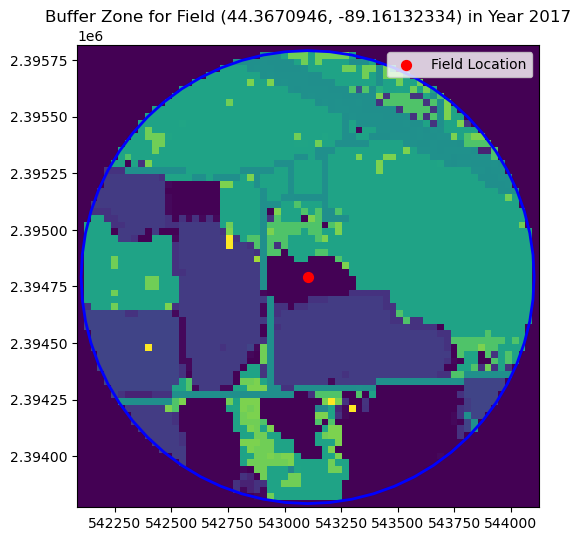

In [74]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import rasterio
from rasterio.plot import show
from rasterio.mask import mask

def plot_field_buffer(lon, lat, year, buffer_size=1000):
    """
    Plot a field with a buffer zone and overlay with raster data for a given year.
    - lon: Longitude of the field
    - lat: Latitude of the field
    - year: Year of the raster data
    - buffer_size: Buffer size in meters
    """
    # Create a GeoDataFrame for the site
    site = gpd.GeoDataFrame({'geometry': [Point(lon, lat)]}, crs="EPSG:4326")
    site = site.to_crs(epsg=5070)  # Transform to a projected CRS for buffering

    # Create the buffer
    buffer = site.buffer(buffer_size)

    # Load the raster data for the given year
    raster_path = f"../Project_X/webData/CDL_{year}_55.tif"
    with rasterio.open(raster_path) as src:
        # Mask the raster to the buffer area
        buffer_geometry = [buffer.geometry.iloc[0].__geo_interface__]
        out_image, out_transform = mask(src, buffer_geometry, crop=True)
        out_meta = src.meta

    # Plot the raster and the buffer
    fig, ax = plt.subplots(figsize=(6, 6))
    show(out_image, transform=out_transform, ax=ax, cmap='viridis')
    site.plot(ax=ax, color='red', markersize=50, label="Field Location")
    gpd.GeoSeries(buffer).plot(ax=ax, edgecolor='blue', facecolor='none', linewidth=2, label="Buffer Zone")

    plt.title(f"Buffer Zone for Field ({lat}, {lon}) in Year {year}")
    plt.legend()
    plt.show()

# Example usage
plot_field_buffer(lon=-89.16132334, lat=44.3670946, year=2017, buffer_size=1000)

In [136]:
print(new_data_sample.shape)
print(old_data_sample.shape)
print(matched_df.shape)
print(unmatched_year_df.shape)
print(unmatched_df.shape)

(3040, 11)
(2105, 7)
(858, 13)
(1021, 6)
(226, 13)


In [138]:
unmatched_year_df.isnull().sum()

old_grower    0
old_field     0
old_year      0
old_loc       0
old_cpba      0
old_cpbl      0
dtype: int64

### Merging datasets

In [142]:
# Define required columns for the final dataset
required_columns = ['grower', 'field', 'year', 'lat', 'lng', 'cpba_count', 'cpbl_count', 'tmin', 'tmax', 'gdd', 'cum_gdd']

# Fix unmatched_final
unmatched_final = unmatched_df.rename(columns={
    "old_grower": "grower",
    "old_field": "field",
    "old_year": "year",
    "old_loc": "location",
    "old_cpba": "cpba_count",
    "old_cpbl": "cpbl_count"
})

# Extract 'lat' and 'lng' from 'location'
unmatched_final[['lat', 'lng']] = unmatched_final['location'].apply(
    lambda loc: pd.Series({'lat': loc[0], 'lng': loc[1]}) if pd.notnull(loc) else pd.Series({'lat': None, 'lng': None})
)

# Remove duplicate columns
unmatched_final = unmatched_final.loc[:, ~unmatched_final.columns.duplicated()]
# Keep only the required columns, set missing columns to None
unmatched_final = unmatched_final[[col for col in unmatched_final.columns if col in required_columns]]
for col in required_columns:
    if col not in unmatched_final.columns:
        unmatched_final[col] = None

# Fix unmatched_year_final
unmatched_year_final = unmatched_year_df.rename(columns={
    "old_grower": "grower",
    "old_field": "field",
    "old_year": "year",
    "old_loc": "location",
    "old_cpba": "cpba_count",
    "old_cpbl": "cpbl_count"
})

# Extract 'lat' and 'lng' from 'location'
unmatched_year_final[['lat', 'lng']] = unmatched_year_final['location'].apply(
    lambda loc: pd.Series({'lat': loc[0], 'lng': loc[1]}) if pd.notnull(loc) else pd.Series({'lat': None, 'lng': None})
)

# Remove duplicate columns
unmatched_year_final = unmatched_year_final.loc[:, ~unmatched_year_final.columns.duplicated()]
# Keep only the required columns, set missing columns to None
unmatched_year_final = unmatched_year_final[[col for col in unmatched_year_final.columns if col in required_columns]]
for col in required_columns:
    if col not in unmatched_year_final.columns:
        unmatched_year_final[col] = None

# Fix new_data_sample to match the required columns
new_data_sample = new_data_sample[[col for col in new_data_sample.columns if col in required_columns]]
for col in required_columns:
    if col not in new_data_sample.columns:
        new_data_sample[col] = None

# Combine new_data_sample with unmatched_final and unmatched_year_final
final_df = pd.concat([new_data_sample, unmatched_final, unmatched_year_final], ignore_index=True)

# Drop duplicates if necessary and reset index
final_df = final_df.drop_duplicates().reset_index(drop=True)

print("Final Dataset Sample:")
print(final_df.head())

Final Dataset Sample:
                    grower           field  year        lat        lng  \
0  Wisconsin Central Farms       1 Necedah  2014  44.057164 -90.040412   
1  Wisconsin Central Farms  13 Nepco N 1/2  2014  44.209406 -90.021382   
2  Wisconsin Central Farms      16 13th St  2014  44.100775 -90.050524   
3  Wisconsin Central Farms      26 Huebner  2014  44.171606 -89.975877   
4  Wisconsin Central Farms        7 N Home  2014  44.329762 -89.931300   

   cpba_count  cpbl_count       tmin       tmax        gdd      cum_gdd  
0    3.307692    3.900000  44.815974  83.173633  13.772113  1727.895721  
1    4.562500    8.714286  45.498328  79.713370  12.804045  1258.997050  
2    1.637500    2.190000  45.224964  82.761841  14.263578  1688.066890  
3    2.181818    4.555556  45.584387  82.216665  13.292737  1500.892541  
4    1.200000    5.500000  45.715179  78.727568  12.237354  1011.682193  


In [146]:
print(new_data_sample.shape)
print(unmatched_final.shape)
print(unmatched_year_final.shape)
print(final_df.shape)

(3040, 11)
(226, 11)
(1021, 11)
(4287, 11)


In [148]:
final_df.isnull().sum()

grower           0
field            0
year             0
lat              0
lng              0
cpba_count       0
cpbl_count       0
tmin          1247
tmax          1247
gdd           1247
cum_gdd       1247
dtype: int64

In [150]:
final_df.to_csv("merged_data/1_final_merged_data.csv", index=False)

### Plots: Abundance Rates in Matching Fields

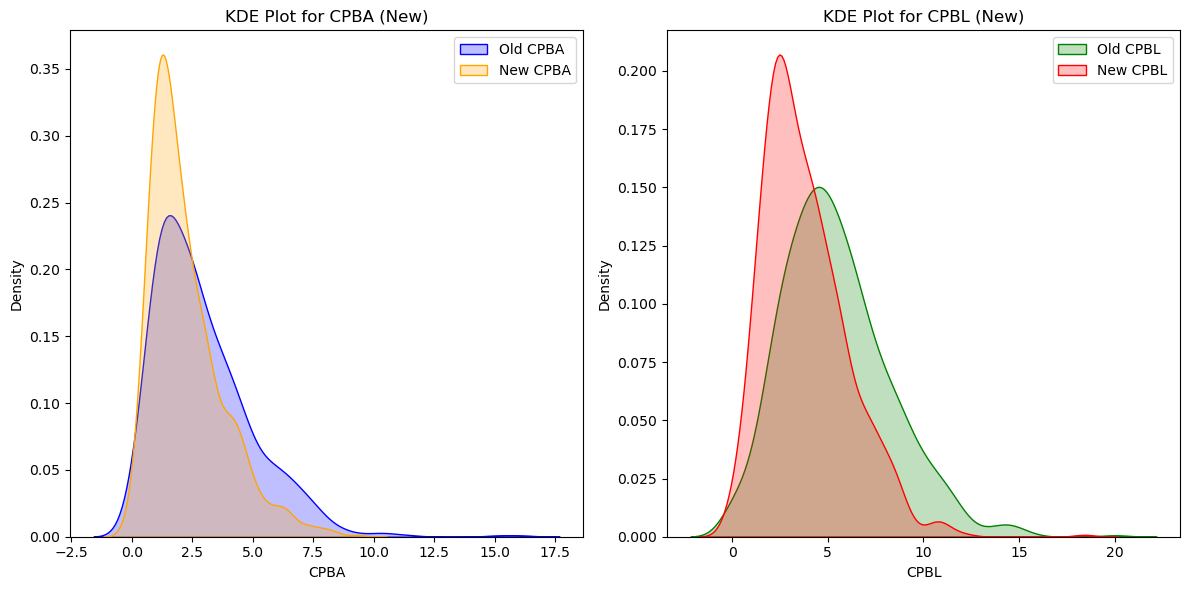

In [118]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# KDE Plot for CPBA
sns.kdeplot(matched_df_sorted['old_cpba'], label='Old CPBA', fill=True, color='blue', ax=axes[0])
sns.kdeplot(matched_df_sorted['new_cpba'], label='New CPBA', fill=True, color='orange', ax=axes[0])
axes[0].set_title('KDE Plot for CPBA (New)')
axes[0].set_xlabel('CPBA')
axes[0].set_ylabel('Density')
axes[0].legend()

# KDE Plot for CPBL
sns.kdeplot(matched_df_sorted['old_cpbl'], label='Old CPBL', fill=True, color='green', ax=axes[1])
sns.kdeplot(matched_df_sorted['new_cpbl'], label='New CPBL', fill=True, color='red', ax=axes[1])
axes[1].set_title('KDE Plot for CPBL (New)')
axes[1].set_xlabel('CPBL')
axes[1].set_ylabel('Density')
axes[1].legend()

plt.tight_layout()
plt.show()

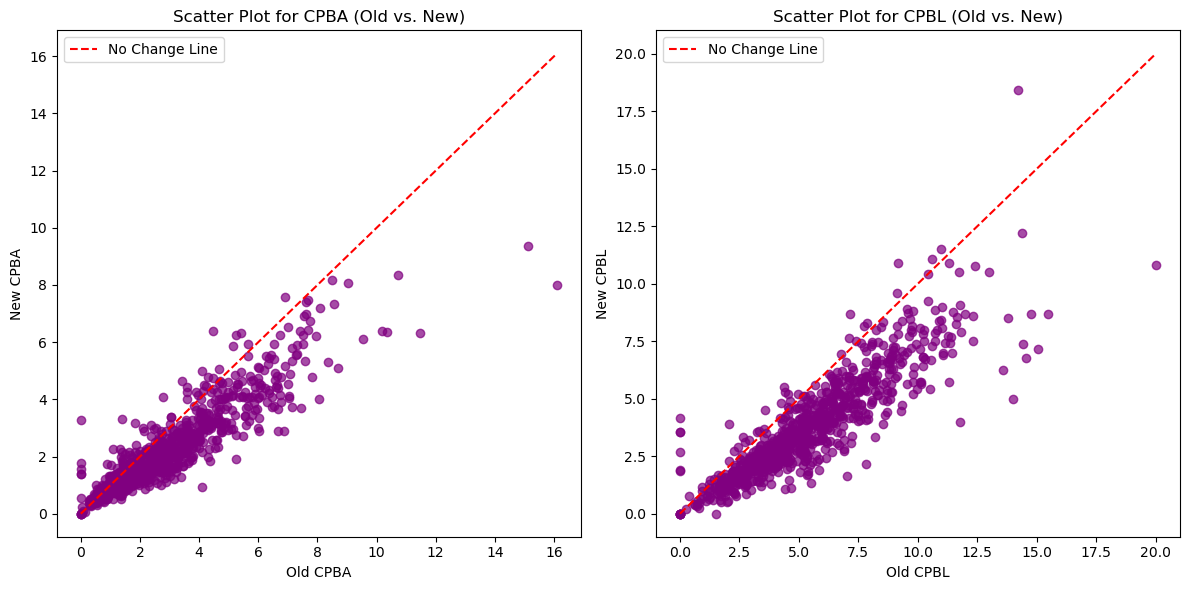

In [122]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Scatter Plot for CPBA
axes[0].scatter(matched_df_sorted['old_cpba'], matched_df_sorted['new_cpba'], color='purple', alpha=0.7)
axes[0].plot([matched_df_sorted['old_cpba'].min(), matched_df_sorted['old_cpba'].max()],
             [matched_df_sorted['old_cpba'].min(), matched_df_sorted['old_cpba'].max()], 
             color='red', linestyle='--', label='No Change Line')
axes[0].set_title('Scatter Plot for CPBA (Old vs. New)')
axes[0].set_xlabel('Old CPBA')
axes[0].set_ylabel('New CPBA')
axes[0].legend()

# Scatter Plot for CPBL
axes[1].scatter(matched_df_sorted['old_cpbl'], matched_df_sorted['new_cpbl'], color='purple', alpha=0.7)
axes[1].plot([matched_df_sorted['old_cpbl'].min(), matched_df_sorted['old_cpbl'].max()],
             [matched_df_sorted['old_cpbl'].min(), matched_df_sorted['old_cpbl'].max()], 
             color='red', linestyle='--', label='No Change Line')
axes[1].set_title('Scatter Plot for CPBL (Old vs. New)')
axes[1].set_xlabel('Old CPBL')
axes[1].set_ylabel('New CPBL')
axes[1].legend()

plt.tight_layout()
plt.show()

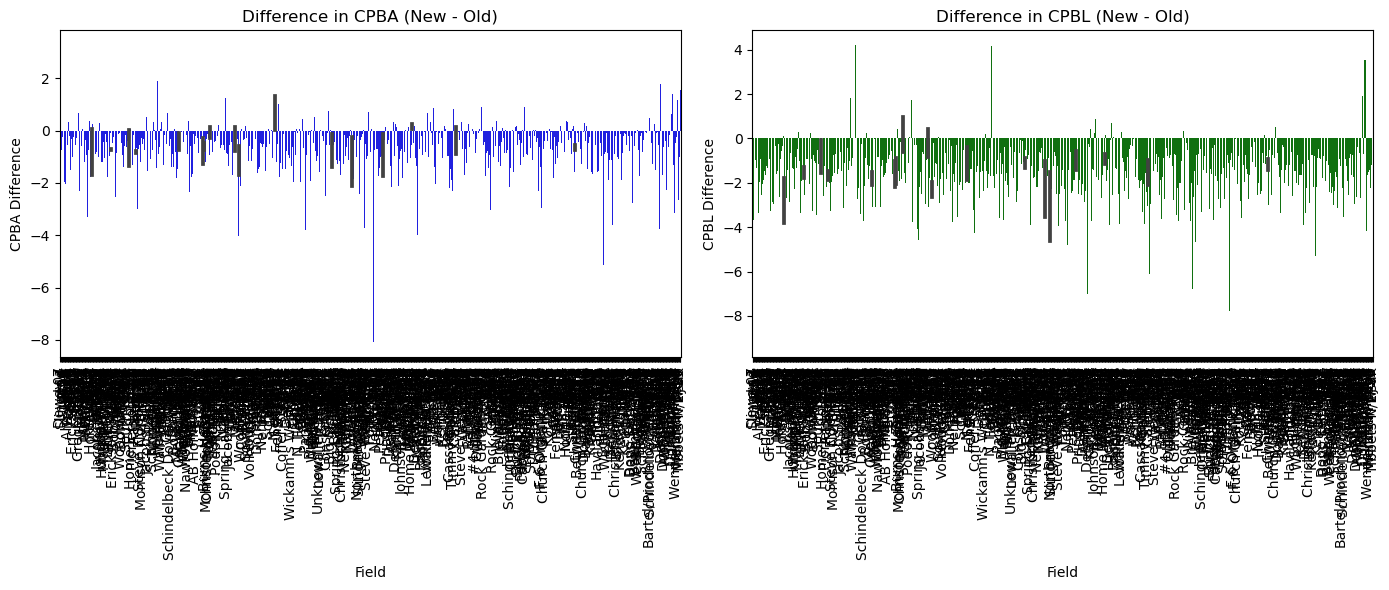

In [132]:
# Calculate differences
matched_df_sorted['cpba_diff'] = matched_df_sorted['new_cpba'] - matched_df_sorted['old_cpba']
matched_df_sorted['cpbl_diff'] = matched_df_sorted['new_cpbl'] - matched_df_sorted['old_cpbl']

# Create subplots for bar plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Use a meaningful column for the x-axis, e.g., 'field'
x_labels = matched_df_sorted['old_field']

# Bar Plot for CPBA Differences
sns.barplot(x=x_labels, y=matched_df_sorted['cpba_diff'], color='blue', ax=axes[0])
axes[0].set_title('Difference in CPBA (New - Old)')
axes[0].set_xlabel('Field')
axes[0].set_ylabel('CPBA Difference')
axes[0].tick_params(axis='x', rotation=90)

# Bar Plot for CPBL Differences
sns.barplot(x=x_labels, y=matched_df_sorted['cpbl_diff'], color='green', ax=axes[1])
axes[1].set_title('Difference in CPBL (New - Old)')
axes[1].set_xlabel('Field')
axes[1].set_ylabel('CPBL Difference')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

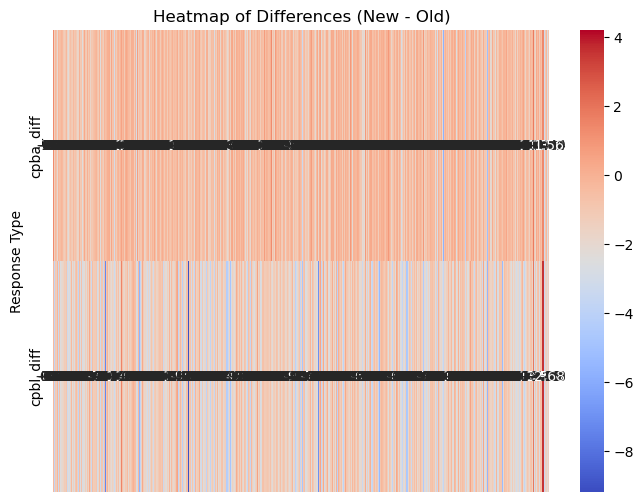

In [128]:
import numpy as np

# Create a heatmap for differences
diff_matrix = matched_df_sorted[['cpba_diff', 'cpbl_diff']].T

plt.figure(figsize=(8, 6))
sns.heatmap(diff_matrix, annot=True, cmap='coolwarm', fmt='.2f', xticklabels=False)
plt.title('Heatmap of Differences (New - Old)')
plt.ylabel('Response Type')
plt.show()

### Here we've used R code to find Intensity and Crope type

Max intensity is: 0.5782744 by field ID: 365 in year: 2019 </br>
Min intensity is: 0 by field ID: 1 in year: 2010 

<div style="display: flex; justify-content: space-between; align-items: center; gap: 50px;">
    <img src="pics/max_intensity_field.png" alt="Raster Data 2005" width="500" height="300" style="margin-right: 10px;">
    <img src="pics/min_intensity_field.png" alt="Raster Data 2008" width="500" height="300">
</div>

In [165]:
fields = pd.read_csv("merged_data/updated_final_fields.csv")
fields.head()

,grower,field,year,lat,lng,cpba_count,cpbl_count,tmin,tmax,gdd,cum_gdd,crop_type,intensity,potato_proportion
0,Wisconsin Central Farms,1 Necedah,2014,44.057164,-90.040412,3.307692,3.900000,44.815974,83.173633,13.772113,1727.895721,43,0.069034,0.4
1,Wisconsin Central Farms,13 Nepco N 1/2,2014,44.209406,-90.021382,4.562500,8.714286,45.498328,79.713370,12.804045,1258.997050,1,0.034770,0.2
2,Wisconsin Central Farms,16 13th St,2014,44.100775,-90.050524,1.637500,2.190000,45.224964,82.761841,14.263578,1688.066890,43,0.103131,0.4
3,Wisconsin Central Farms,26 Huebner,2014,44.171606,-89.975877,2.181818,4.555556,45.584387,82.216665,13.292737,1500.892541,43,0.068644,0.4
4,Wisconsin Central Farms,7 N Home,2014,44.329762,-89.931300,1.200000,5.500000,45.715179,78.727568,12.237354,1011.682193,43,0.034145,0.4


In [167]:
fields.shape

(4287, 14)

In [176]:
fields.isnull().sum()

grower                  0
field                   0
year                    0
lat                     0
lng                     0
cpba_count              0
cpbl_count              0
tmin                 1247
tmax                 1247
gdd                  1247
cum_gdd              1247
crop_type               0
intensity               0
potato_proportion       0
dtype: int64

### Add climate data

In [178]:
import time
from meteostat import Daily, Point
from datetime import datetime
import pandas as pd

def get_climate_data(lat, lon, year, start_month=None, end_month=None):
    location = Point(lat, lon)
    start_date = datetime(year, start_month, 1) if start_month else datetime(year, 1, 1)
    end_date = datetime(year, end_month, 28 if start_month == 2 else 31) if end_month else datetime(year, 12, 31)
    climate_data = Daily(location, start_date, end_date).fetch()

    return {
        'tmin': climate_data['tmin'].min() if 'tmin' in climate_data else None,
        'tmax': climate_data['tmax'].max() if 'tmax' in climate_data else None,
        'prcp': climate_data['prcp'].mean() if 'prcp' in climate_data else None,
        'tavg': climate_data['tavg'].mean() if 'tavg' in climate_data else None
    }

# Function to add climate data to the dataset
def add_climate_info(df):
    print("Starting climate data processing...")
    start_time = time.time()  # Start the timer

    climate_data_list = []

    for idx, row in df.iterrows():
        lat, lon, year = row['lat'], row['lng'], row['year']

        # Annual metrics
        annual_data = get_climate_data(lat, lon, year)
        tmin_annual = annual_data['tmin']
        tmax_annual = annual_data['tmax']
        annual_prcp = annual_data['prcp']

        # Summer metrics
        summer_data = get_climate_data(lat, lon, year, start_month=5, end_month=8)
        summer_tmin = summer_data['tmin']
        summer_avg = summer_data['tavg']
        summer_prcp = summer_data['prcp']

        # Winter metrics (previous December + current year January-February)
        winter_data = pd.concat([
            Daily(Point(lat, lon), datetime(year - 1, 12, 1), datetime(year - 1, 12, 31)).fetch(),
            Daily(Point(lat, lon), datetime(year, 1, 1), datetime(year, 2, 28)).fetch()
        ])
        winter_avg = winter_data['tavg'].mean() if 'tavg' in winter_data.columns else None
        winter_tmax = winter_data['tmax'].max() if 'tmax' in winter_data.columns else None

        # Append results
        climate_data_list.append({
            'tmin_annual': tmin_annual,
            'tmax_annual': tmax_annual,
            'annual_prcp': annual_prcp,
            'summer_tmin': summer_tmin,
            'summer_avg': summer_avg,
            'summer_prcp': summer_prcp,
            'winter_avg': winter_avg,
            'winter_tmax': winter_tmax
        })

        # Progress tracking
        if idx % (len(df) // 10) == 0:
            print(f"Processed {int((idx / len(df)) * 100)}% of rows...")

    # End the timer and print processing time
    end_time = time.time()
    print(f"Climate data processing completed in {end_time - start_time:.2f} seconds.")

    # Combine climate data with the original dataset
    climate_df = pd.DataFrame(climate_data_list)
    return pd.concat([df.reset_index(drop=True), climate_df], axis=1)

fields_with_climate = add_climate_info(fields)

fields_with_climate.to_csv("merged_data/5_fields_with_climate.csv", index=False)

print("Updated dataset saved to 'merged_data/fields_with_climate.csv'.")

Starting climate data processing...
Processed 0% of rows...
Processed 9% of rows...
Processed 19% of rows...
Processed 29% of rows...
Processed 39% of rows...
Processed 49% of rows...
Processed 59% of rows...
Processed 69% of rows...
Processed 79% of rows...
Processed 89% of rows...
Processed 99% of rows...
Climate data processing completed in 158.05 seconds.
Updated dataset saved to 'merged_data/fields_with_climate.csv'.


In [180]:

fields_with_climate

,grower,field,year,lat,lng,cpba_count,cpbl_count,tmin,tmax,gdd,...,intensity,potato_proportion,tmin_annual,tmax_annual,annual_prcp,summer_tmin,summer_avg,summer_prcp,winter_avg,winter_tmax
0,Wisconsin Central Farms,1 Necedah,2014,44.057164,-90.040412,3.307692,3.900000,44.815974,83.173633,13.772113,...,0.069034,0.4,-30.9,31.0,NaN,-4.7,18.290083,NaN,-12.111905,7.0
1,Wisconsin Central Farms,13 Nepco N 1/2,2014,44.209406,-90.021382,4.562500,8.714286,45.498328,79.713370,12.804045,...,0.034770,0.2,-31.1,31.1,1.244492,-1.1,18.627049,1.473810,-12.090588,6.1
2,Wisconsin Central Farms,16 13th St,2014,44.100775,-90.050524,1.637500,2.190000,45.224964,82.761841,14.263578,...,0.103131,0.4,-30.9,31.0,1.244492,-4.7,18.342276,1.473810,-11.597778,7.0
3,Wisconsin Central Farms,26 Huebner,2014,44.171606,-89.975877,2.181818,4.555556,45.584387,82.216665,13.292737,...,0.068644,0.4,-31.1,31.1,1.244492,-1.1,18.633333,1.473810,-12.063333,6.1
4,Wisconsin Central Farms,7 N Home,2014,44.329762,-89.931300,1.200000,5.500000,45.715179,78.727568,12.237354,...,0.034145,0.4,-31.1,31.1,1.244492,-1.1,18.627049,1.473810,-12.090588,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,Weekly Farms,Slinger 1,2017,44.159749,-89.577698,5.273333,6.220000,NaN,NaN,NaN,...,0.338670,0.4,-27.2,32.8,1.425843,-2.8,18.056098,1.675258,-4.538889,19.4
4283,Weekly Farms,Stannard,2017,44.171888,-89.478248,1.584615,2.646154,NaN,NaN,NaN,...,0.215280,0.2,-27.2,32.8,1.004032,-2.8,18.000990,0.811765,-4.343284,19.4
4284,Weekly Farms,Tibbets Big,2017,44.200958,-89.571456,4.225000,7.575000,NaN,NaN,NaN,...,0.188199,0.4,-27.2,32.8,1.414981,-2.2,18.234959,1.616495,-4.865556,16.7
4285,Weekly Farms,Waterman,2016,44.188617,-89.528882,0.000000,0.000000,NaN,NaN,NaN,...,0.118947,0.4,-27.2,33.3,2.215439,-3.9,19.357724,2.963303,-3.326667,14.4


In [192]:
fields_with_climate.isnull().sum()

grower                  0
field                   0
year                    0
lat                     0
lng                     0
cpba_count              0
cpbl_count              0
tmin                 1247
tmax                 1247
gdd                  1247
cum_gdd              1247
crop_type               0
intensity               0
potato_proportion       0
tmin_annual           338
tmax_annual           338
annual_prcp          1120
summer_tmin           338
summer_avg            338
summer_prcp          1206
winter_avg            442
winter_tmax           442
dtype: int64

In [194]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

df_with_climate = pd.read_csv("merged_data/5_fields_with_climate.csv")

missing_cols = [
    'tmin_annual', 'tmax_annual', 'annual_prcp',
    'summer_tmin', 'summer_avg', 'summer_prcp',
    'winter_avg', 'winter_tmax'
]

# Step 2: Separate rows with missing and non-missing values
missing_rows = df_with_climate[df_with_climate[missing_cols].isnull().any(axis=1)]
non_missing_rows = df_with_climate.dropna(subset=missing_cols)

# Step 3: Use spatial coordinates to find the nearest non-missing field
null_coords = missing_rows[['lat', 'lng']].values
non_null_coords = non_missing_rows[['lat', 'lng']].values

# Create a cKDTree for efficient nearest neighbor search
tree = cKDTree(non_null_coords)
distances, indices = tree.query(null_coords, k=1)

# Step 4: Fill missing values with data from the nearest non-missing field
for i, missing_index in enumerate(missing_rows.index):
    nearest_index = non_missing_rows.index[indices[i]]
    for col in missing_cols:
        if pd.isnull(df_with_climate.loc[missing_index, col]):
            df_with_climate.loc[missing_index, col] = df_with_climate.loc[nearest_index, col]

# Step 5: Verify the filled DataFrame
print("Missing values after filling:")
print(df_with_climate[missing_cols].isnull().sum())

# Save the updated dataset
df_with_climate.to_csv("merged_data/fields_with_climate_filled.csv", index=False)

print("Updated dataset saved to 'merged_data/6_with_climate_filled.csv'.")

Missing values after filling:
tmin_annual    0
tmax_annual    0
annual_prcp    0
summer_tmin    0
summer_avg     0
summer_prcp    0
winter_avg     0
winter_tmax    0
dtype: int64
Updated dataset saved to 'merged_data/fields_with_climate_filled.csv'.


In [196]:
df_with_climate

,grower,field,year,lat,lng,cpba_count,cpbl_count,tmin,tmax,gdd,...,intensity,potato_proportion,tmin_annual,tmax_annual,annual_prcp,summer_tmin,summer_avg,summer_prcp,winter_avg,winter_tmax
0,Wisconsin Central Farms,1 Necedah,2014,44.057164,-90.040412,3.307692,3.900000,44.815974,83.173633,13.772113,...,0.069034,0.4,-30.9,31.0,3.098630,-4.7,18.290083,3.366667,-12.111905,7.0
1,Wisconsin Central Farms,13 Nepco N 1/2,2014,44.209406,-90.021382,4.562500,8.714286,45.498328,79.713370,12.804045,...,0.034770,0.2,-31.1,31.1,1.244492,-1.1,18.627049,1.473810,-12.090588,6.1
2,Wisconsin Central Farms,16 13th St,2014,44.100775,-90.050524,1.637500,2.190000,45.224964,82.761841,14.263578,...,0.103131,0.4,-30.9,31.0,1.244492,-4.7,18.342276,1.473810,-11.597778,7.0
3,Wisconsin Central Farms,26 Huebner,2014,44.171606,-89.975877,2.181818,4.555556,45.584387,82.216665,13.292737,...,0.068644,0.4,-31.1,31.1,1.244492,-1.1,18.633333,1.473810,-12.063333,6.1
4,Wisconsin Central Farms,7 N Home,2014,44.329762,-89.931300,1.200000,5.500000,45.715179,78.727568,12.237354,...,0.034145,0.4,-31.1,31.1,1.244492,-1.1,18.627049,1.473810,-12.090588,6.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4282,Weekly Farms,Slinger 1,2017,44.159749,-89.577698,5.273333,6.220000,NaN,NaN,NaN,...,0.338670,0.4,-27.2,32.8,1.425843,-2.8,18.056098,1.675258,-4.538889,19.4
4283,Weekly Farms,Stannard,2017,44.171888,-89.478248,1.584615,2.646154,NaN,NaN,NaN,...,0.215280,0.2,-27.2,32.8,1.004032,-2.8,18.000990,0.811765,-4.343284,19.4
4284,Weekly Farms,Tibbets Big,2017,44.200958,-89.571456,4.225000,7.575000,NaN,NaN,NaN,...,0.188199,0.4,-27.2,32.8,1.414981,-2.2,18.234959,1.616495,-4.865556,16.7
4285,Weekly Farms,Waterman,2016,44.188617,-89.528882,0.000000,0.000000,NaN,NaN,NaN,...,0.118947,0.4,-27.2,33.3,2.215439,-3.9,19.357724,2.963303,-3.326667,14.4


### Some plots

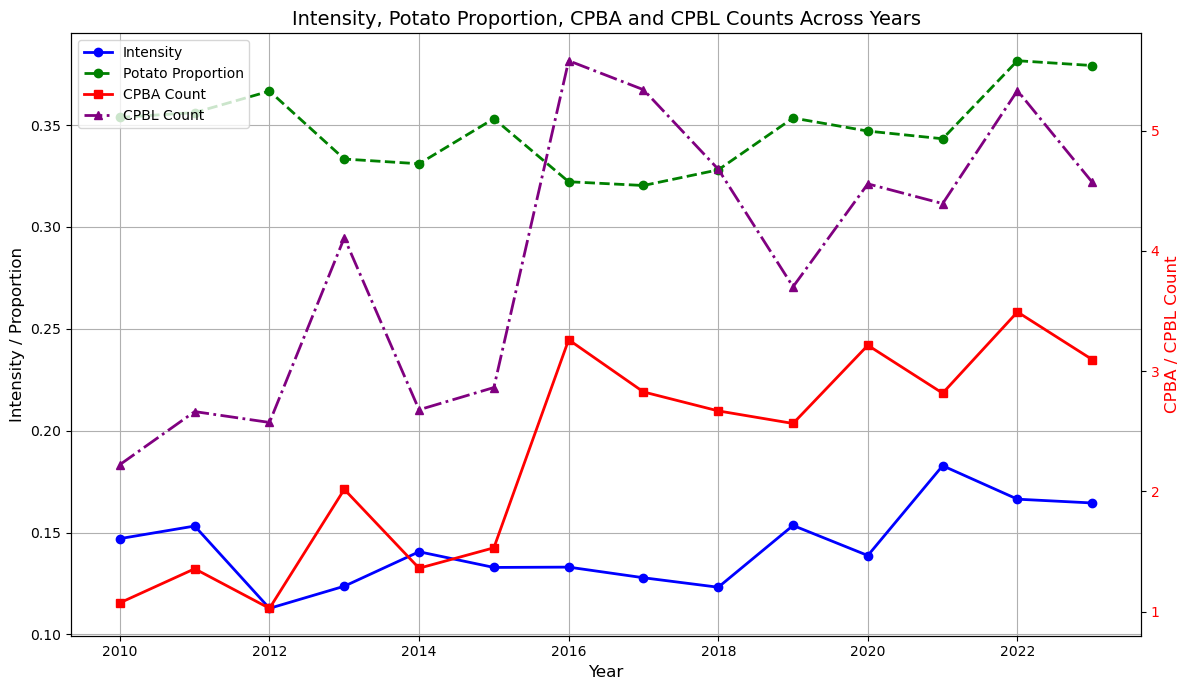

In [199]:
import matplotlib.pyplot as plt

# Step 1: Group data by year and calculate the mean for relevant columns
yearly_summary = df_with_climate.groupby('year').agg({
    'intensity': 'mean',
    'potato_proportion': 'mean',
    'cpba_count': 'mean',
    'cpbl_count': 'mean'
}).reset_index()

# Step 2: Create the plot
fig, ax1 = plt.subplots(figsize=(12, 7))

# Plot Intensity and Potato Proportion (Left Y-Axis)
ax1.plot(yearly_summary['year'], yearly_summary['intensity'], 
         label='Intensity', color='blue', marker='o', linewidth=2)
ax1.plot(yearly_summary['year'], yearly_summary['potato_proportion'], 
         label='Potato Proportion', color='green', marker='o', linestyle='--', linewidth=2)

ax1.set_xlabel("Year", fontsize=12)
ax1.set_ylabel("Intensity / Proportion", fontsize=12, color='black')
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True)

# Create a secondary Y-axis for CPBA and CPBL counts
ax2 = ax1.twinx()
ax2.plot(yearly_summary['year'], yearly_summary['cpba_count'], 
         label='CPBA Count', color='red', marker='s', linewidth=2)
ax2.plot(yearly_summary['year'], yearly_summary['cpbl_count'], 
         label='CPBL Count', color='purple', marker='^', linestyle='-.', linewidth=2)

ax2.set_ylabel("CPBA / CPBL Count", fontsize=12, color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left', fontsize=10)

# Add title and layout adjustments
plt.title("Intensity, Potato Proportion, CPBA and CPBL Counts Across Years", fontsize=14)
plt.tight_layout()

# Display the plot
plt.show()